# Importing the necessary packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , classification_report
from imblearn.over_sampling import SMOTE
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
mpl.rcParams['figure.figsize'] = (15, 18)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Read the data

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('week_approach_maskedID_timeseries.csv')
convert_dict = {'nr. sessions': int } #convert nr.sessions to int 
raw_df = raw_df.astype(convert_dict)
raw_df.head()

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
0,5,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.0,0.18,0.16,0.20,0,0,0.718447,1.378882,1.919255,0
1,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.20,0,0,0.683544,1.018868,1.490566,1
2,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,0.683544,1.018868,1.490566,2
3,5,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.18,0,0,0.683544,1.018868,1.490566,3
4,6,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,2.202247,1.361111,0.618056,4


In [4]:
# This section displays the percentage of the majority class
neg, pos = np.bincount(raw_df['injury'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 42798
    Positive: 575 (1.34% of total)



In [5]:
#Dropping the unnecessary columns/features
cleaned_df = raw_df.copy()
cleaned_df.pop('Date')
cleaned_df.pop('Athlete ID')

0         0
1         0
2         0
3         0
4         0
         ..
42793    71
42794    71
42795    71
42796    71
42797    71
Name: Athlete ID, Length: 42798, dtype: int64

In [6]:
X = cleaned_df.drop('injury', axis = 1)
y = cleaned_df['injury']

In [7]:
X.shape[1]

69

# Applying Synthetic Minority Oversampling Technique (SMOTE)

In [8]:
#This is because the data is so imbalanced. The minority class is oversampled with new similar data is generated to compensate its minimal numbers
smote_technique = SMOTE(sampling_strategy='minority')
X_smt, y_smt = smote_technique.fit_resample(X, y)

In [9]:
y_smt.value_counts() #class counts now match

0    42223
1    42223
Name: injury, dtype: int64

In [10]:
#Data is split to Train and test 
X_train_smt, X_test_smt, y_train_smt, y_test_smt = train_test_split(X_smt, y_smt, test_size=0.3, random_state=15, stratify=y_smt)


# Defining the Deep Nearal Network Model

In [11]:
dnn_model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(X.shape[1],), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=20,
    mode='min',
    restore_best_weights=True)

2022-10-19 21:37:28.374236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [13]:
#Model compliation
dnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=METRICS)

In [14]:
dnn_model.fit(X_train_smt, y_train_smt, callbacks = [early_stopping], epochs=300)

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1848/1848 [==============================] - 13s 5ms/step - loss: 9101.6182 - tp: 23925.0000 - fp: 21342.0000 - tn: 8214.0000 - fn: 5631.0000 - accuracy: 0.5437 - precision: 0.5285 - recall: 0.8095 - auc: 0.5488 - prc: 0.5260
Epoch 2/300
1848/1848 [==============================] - 6s 3ms/step - loss: 255.9767 - tp: 26531.0000 - fp: 23229.0000 - tn: 6327.0000 - fn: 3025.0000 - accuracy: 0.5559 - precision: 0.5332 - recall: 0.8977 - auc: 0.5810 - prc: 0.5472
Epoch 3/300
1848/1848 [==============================] - 6s 3ms/step - loss: 58.3451 - tp: 24537.0000 - fp: 20096.0000 - tn: 9460.0000 - fn: 5019.0000 - accuracy: 0.5751 - precision: 0.5498 - recall: 0.8302 - auc: 0

In [15]:
#Using the trained model, the prediction is done on the test set
dnn_preds_smt = dnn_model.predict(X_test_smt)
dnn_preds_smt = np.round(dnn_preds_smt)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
792/792 [==============================] - 5s 4ms/step


In [16]:
#Display the classification report of the model out of prediction using the test data
print(classification_report(y_test_smt,dnn_preds_smt))


              precision    recall  f1-score   support

           0       0.85      0.66      0.74     12667
           1       0.72      0.88      0.79     12667

    accuracy                           0.77     25334
   macro avg       0.78      0.77      0.77     25334
weighted avg       0.78      0.77      0.77     25334



In [17]:
#function to display the confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  8320
Legitimate Transactions Incorrectly Detected (False Positives):  4347
Fraudulent Transactions Missed (False Negatives):  1488
Fraudulent Transactions Detected (True Positives):  11179
Total Fraudulent Transactions:  12667


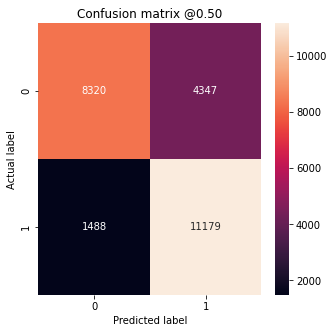

In [18]:
plot_cm(y_test_smt, dnn_preds_smt)

# Saving the trained Model

In [19]:
# Calling `save('my_model')` creates a SavedModel folder `dnn_model`.
dnn_model.save("weekly_dnn_model")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Sample prediction

In [20]:
def predict(model, record):
    k = np.array(record).reshape(1,69)
    prediction = int(np.round(dnn_model.predict(k))[0][0])
    return prediction

In [21]:
#Sample record to predict
k = np.array(X_test_smt.iloc[1]).reshape(1,69)

In [22]:
k

array([[ 7.        ,  1.        , 57.37102434, 16.94058534, 11.27089431,
         2.34178861,  2.34178861,  0.        ,  0.        ,  9.86835772,
         5.86835772,  0.        ,  1.31642278,  0.42644878,  0.20556748,
         0.67049431,  0.50024066,  0.42125529,  0.53973334,  0.23873171,
         0.16265691,  0.36720976,  5.65821139,  2.        , 46.9747642 ,
        14.44552847,  6.91268292,  1.68357722,  1.68357722,  0.13671544,
         0.13671544,  6.03417886,  5.00881303,  0.        ,  0.65821139,
         0.28164228,  0.14632846,  0.55518049,  0.43441952,  0.26986667,
         0.55289757,  0.28822439,  0.17949268,  0.54834472,  7.        ,
         1.        , 65.16848776, 17.00881303, 14.40747972,  2.65821139,
         3.        ,  0.68357722,  0.68357722, 12.51375616,  5.23791872,
         0.        ,  1.65821139,  0.40670244,  0.24847805,  0.5978374 ,
         0.46074797,  0.37518049,  0.50024066,  0.29138862,  0.21873171,
         0.52201626,  1.22014489,  0.87982344,  0.7

In [23]:
#Predict using the loaded saved model
reconstructed_model = keras.models.load_model("weekly_dnn_model")

In [24]:
predict(reconstructed_model,k)

1/1 [==============================] - 0s 152ms/step


1